#### Question 2 :
 On considère dans le modèle de Black & Scholes une option asiatique arithm´etique discr` ete de
 maturit´e T et de strike K. On pourra prendre comme valeurs de référence $S_0 = 100$, $K = 100$,
 $T=1$, $r=0.05$, $σ=0.20$, $d=12$, $N=105$.
 1. Tracer en fonction de S0 sur un même graphe le prix exact du call européen et le prix
 Monte Carlo de l’option asiatique de mêmes strike et maturité à d dates. Commenter.

In [2]:
## import cell
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [3]:
## basic functions
def black_scholes_european_call(S=100, K=100, T=1, r=0.05, sigma=0.2):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    return {'Price' : S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2), 'Variance' : 0}

def monte_carlo_asian_call(S=100, K=100, T=1, r=0.05, sigma=0.2, d=12, N=int(1e5)):
    step = T / d
    simulations = np.zeros((N, d+1))
    simulations[:,0] = S
    for iter in range(N):
        for t in range(1,d+1):
            dx = np.random.normal()
            simulations[iter, t] = simulations[iter, t-1]*np.exp((r - 0.5 * sigma ** 2) * step + sigma * np.sqrt(step) * dx)
    realized_payoff = np.exp(-r * T) * np.maximum(np.mean(simulations[:, 1:], axis=1) - K, 0)
    return {'Price' : np.mean(realized_payoff), 'Variance' : np.var(realized_payoff)}

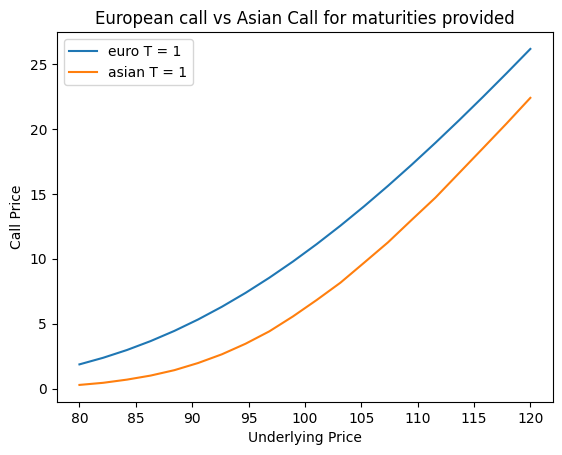

In [4]:
### Graphiques exemples
## initialisation des paramètres
K = 100
r = 0.05
sigma = 0.2
d = 12
N = int(1e5) # pour plus de rapidité de calcul
nb_prices = 20
Unders = np.linspace(0.8*K,1.2*K, nb_prices) ## prix du sous-jacent
Maturities = [1] 
colors = plt.get_cmap("tab10").colors

Prices = np.zeros((2*len(Maturities),nb_prices))
for i_T, T in enumerate(Maturities):
    for i, S in enumerate(Unders):
        european = black_scholes_european_call(S,K,T,r,sigma)
        asian = monte_carlo_asian_call(S,K,T,r,sigma,d,N)
        Prices[i_T,i] = european['Price']
        Prices[i_T + 1,i] = asian['Price']
        
    plt.plot(Unders, Prices[i_T,:],color=colors[i_T%len(colors)], markersize=2, label=f'euro T = {T}')
    plt.plot(Unders, Prices[i_T+1,:],color=colors[i_T+1%len(colors)], markersize=2, label=f'asian T = {T}')
    
plt.title(f'European call vs Asian Call for maturities provided')
plt.xlabel('Underlying Price')
plt.ylabel('Call Price')
plt.legend()
plt.show()

Commentaires : C_asian < C_europeen. Le payoff asiatique est plus "lisse" que le classique, donc moins risqué pour l'émetteur du contrat, ce qui réduit la prime. 
On peut églament le voir en disant qu'une forte montée du prix du sous-jacent a une grande probabilité d'arriver après une ou plusieurs dates $t_i$, et le retour à l'investisseur sera amoindri à cause des valeurs précédentes qui entrent en compte. On alloue donc une prime plus faible. 
A l'inverse, si une forte variation à la baisse intervient, les deux options ont un payoff nul, donc cet evènement extrême ne contribue pas au dimensionnement de la prime.

2)  Prix Monte Carlo de l’option asiatique et l’intervalle de confiance en fonction du nombre de dates d’observations d.

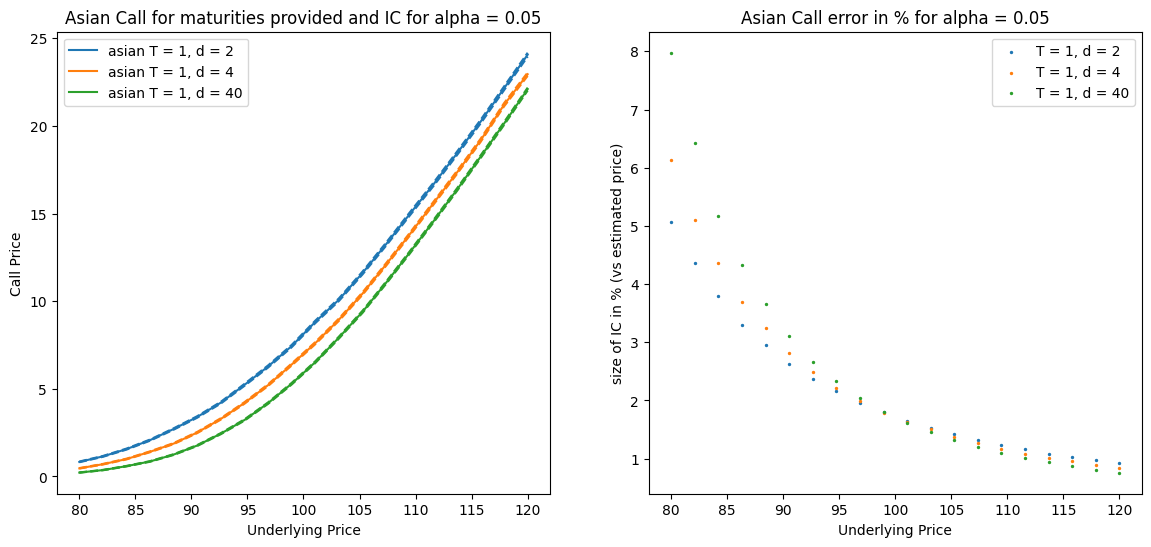

In [5]:
Unders = np.linspace(0.8*K,1.2*K, nb_prices) ## prix du sous-jacent
Maturities = [1] 
times = [2,4,40]
colors = plt.get_cmap("tab10").colors
alpha = 0.05

def plotting(Unders, Maturities, times, alpha,f):
    eps = 1e-5 ## we add to avoid diving by 0
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    Prices = np.zeros((3*len(Maturities),nb_prices,len(times)))
    pct_errors = np.zeros((len(Maturities),nb_prices,len(times)))
    for i_T, T in enumerate(Maturities):
        for i_d, d in enumerate(times):
            for i, S in enumerate(Unders):  
                X = f(S,K,T,r,sigma,d,N)
                
                price = X['Price']
                s2 = X['Variance']
                q_aplha = stats.norm.ppf(1 - alpha / 2)
                
                Prices[i_T*3,i,i_d] = price + np.sqrt(s2/N) * q_aplha
                Prices[i_T*3 + 1,i,i_d] = price
                Prices[i_T*3 + 2,i,i_d] = price - np.sqrt(s2/N) * q_aplha
                
                pct_errors[i_T,i,i_d] = 100 * 2 * np.sqrt(s2/N) * q_aplha / (price+eps)
          
            ax1.plot(Unders, Prices[3*i_T,:, i_d],color=colors[(i_T+i_d)%len(colors)], markersize=2, linestyle='--')
            ax1.plot(Unders, Prices[3*i_T+1,:,i_d],color=colors[(i_T+i_d)%len(colors)], markersize=2, label=f'asian T = {T}, d = {d}')
            ax1.plot(Unders, Prices[3*i_T+2,:,i_d],color=colors[(i_T+i_d)%len(colors)], markersize=2, linestyle='--')
            ax2.scatter(Unders, pct_errors[i_T,:,i_d],color=colors[(i_T+i_d)%len(colors)], s=2, label=f'T = {T}, d = {d}',marker='o')
       
    ax1.set_title(f'Asian Call for maturities provided and IC for alpha = {alpha}')
    ax1.set_xlabel('Underlying Price')
    ax1.set_ylabel('Call Price')
    ax1.legend()
    
    ax2.set_title(f'Asian Call error in % for alpha = {alpha}')
    ax2.set_xlabel('Underlying Price')
    ax2.set_ylabel('size of IC in % (vs estimated price)')
    ax2.legend()
    plt.show()

plotting(Unders, Maturities, times, alpha, monte_carlo_asian_call)


Commentaires : a priori à gauche, il semble que la marge d'erreur reste assez faible pour $N = 10^5$. 
Mais en se plaçant en relatif par rapport au prix de l'option, on constate que le prix réél peut aller jusqu'à +- 1% du prix estimé (à la monnaie), alors même que le nombre d'itérations est déjà elevé et que la maturité n'est pas très lointaine. Ce n'est pas admissible pour un trader. D'où le besoin de contrôler la variance.

Remarque : $d_1 > d_2 => C_1 < C_2$. En effet, davantage de lissage à mesure que $d$ augmente, donc prix moins élevé.

Commentaire : 

3) Calculer le prix de l’option asiatique avec la variable de contrôle $Z = S_T$ (que vaut $E[Z]$ ?). Vérifier que le prix Monte Carlo avec la variable de contrôle est correct. 
Quel est le facteur de réduction de variance obtenu? Estimer par simulation le facteur de réduction théorique

Commentaire : $E(Z) = e^{rT} S_0$ d'après la forme de $S_t$. 
On obtient le facteur de réduction suivant : $1 - \rho^2((\frac{1}{d}\sum_{i=1}^dS_{t_i}- K)_+,S_T)$

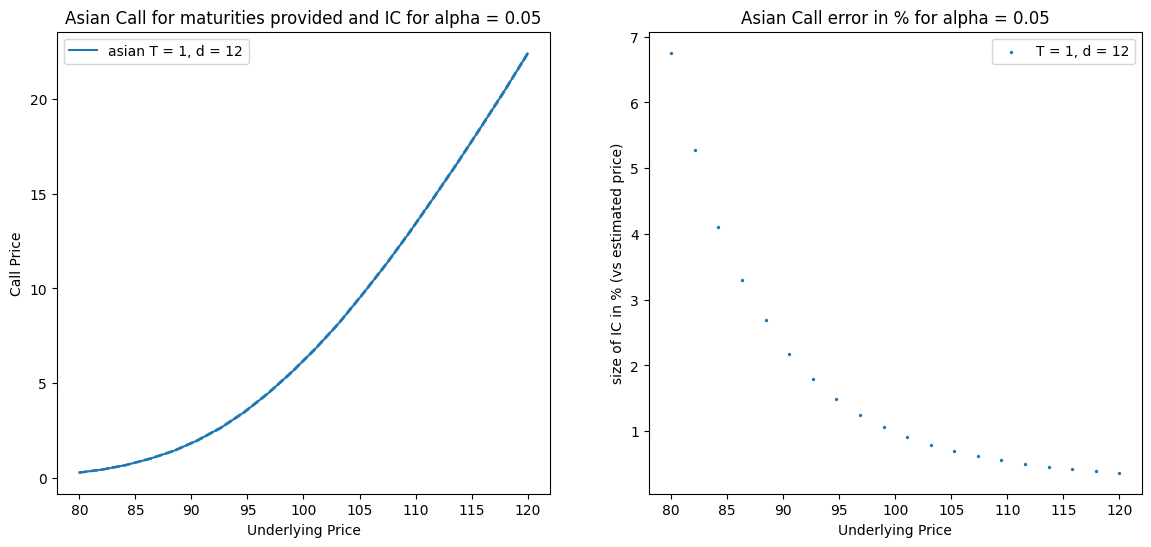

Variance reduction factor is, after emprirical estimation, 0.33


In [6]:
def monte_carlo_asian_call_ST(S=100, K=100, T=1, r=0.05, sigma=0.2, d=12, N=int(1e5)):
    step = T / d
    simulations = np.zeros((N, d+1))
    simulations[:,0] = S
    S_T_simulations = np.zeros(N)
    for iter in range(N):
        for t in range(1,d+1):
            dx = np.random.normal()
            simulations[iter, t] = simulations[iter, t-1]*np.exp((r - 0.5 * sigma ** 2) * step + sigma * np.sqrt(step) * dx)
        S_T_simulations[iter] = simulations[iter,-1]
    
    realized_payoff = np.maximum(np.mean(simulations[:, 1:], axis=1) - K, 0)
        
    # here we can approach the optimal c_star by computing rho(payoff,S_T) :
    cov = np.cov(realized_payoff,S_T_simulations)
    c_star = - cov[0,1]/cov[1,1]
    E_S_T = S * np.exp(r * T)
    
    adj_realized = np.exp(-r * T) * (realized_payoff + c_star * (S_T_simulations - E_S_T))
    return {'Price': np.mean(adj_realized), 'Variance': np.var(adj_realized), 'Corr' : np.corrcoef(realized_payoff,S_T_simulations)}
        
Unders = np.linspace(0.8*K,1.2*K, nb_prices) ## prix du sous-jacent
Maturities = [1] 
colors = plt.get_cmap("tab10").colors
times = [12]
alpha =0.05

plotting(Unders, Maturities,times, alpha,monte_carlo_asian_call_ST)

coeff = 1-monte_carlo_asian_call_ST()['Corr']**2
print(f'Variance reduction factor is, after emprirical estimation, {np.round(coeff[1,0],2)}')

Commentaire : on doit théoriquement diviser la variance par 3 environ. Cela reste insuffisant, si l'on souhaite par exemple donner le prix à moins de 5 bp près à la monnaie pour $T=1$, sans augmenter davantage $N$.

4) On prend désormais $Z_1 = \frac{1}{d}\sum_{i=1}^dS_{t_i}$ puis $Z_2 = (S_T - K)_+$

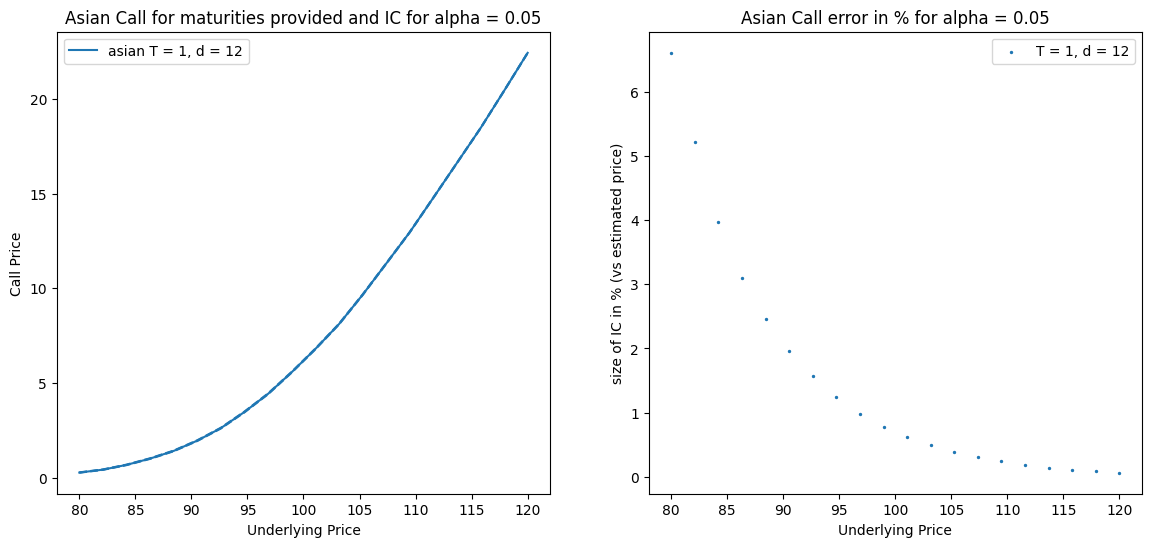

Variance reduction factor is, after emprirical estimation, 0.16


In [7]:
def monte_carlo_asian_call_Z1(S=100, K=100, T=1, r=0.05, sigma=0.2, d=12, N=int(1e5)):
    step = T / d
    simulations = np.zeros((N, d+1))
    simulations[:,0] = S
    for iter in range(N):
        for t in range(1,d+1):
            dx = np.random.normal()
            simulations[iter, t] = simulations[iter, t-1]*np.exp((r - 0.5 * sigma ** 2) * step + sigma * np.sqrt(step) * dx)
    Z = np.mean(simulations[:, 1:], axis=1)
    realized_payoff = np.maximum(np.mean(simulations[:, 1:], axis=1) - K, 0)
        
    # here we can approach the optimal c_star by computing rho(payoff,S_T) :
    cov = np.cov(realized_payoff,Z)
    c_star = - cov[0,1]/cov[1,1]
    E_Z = np.mean(Z)
    
    adj_realized = np.exp(-r * T) * (realized_payoff + c_star * (Z - E_Z))
    return {'Price': np.mean(adj_realized), 'Variance': np.var(adj_realized), 'Corr' : np.corrcoef(realized_payoff,Z)}

plotting(Unders, Maturities,times, alpha,monte_carlo_asian_call_Z1)

coeff = 1-monte_carlo_asian_call_Z1()['Corr']**2
print(f'Variance reduction factor is, after emprirical estimation, {np.round(coeff[1,0],2)}')

Commentaire : facteur de division > 5, encore mieux. Prévisible car Z ressemble davantage au payoff de l'option asiatique que simplement $S_T$.

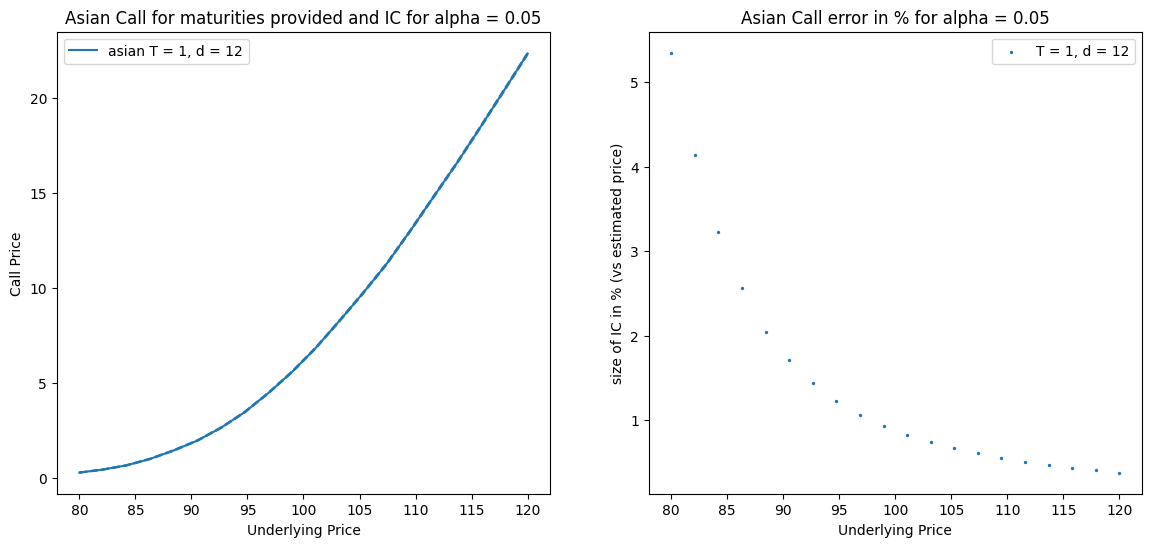

Variance reduction factor is, after emprirical estimation, 0.26


In [8]:
def monte_carlo_asian_call_Z2(S=100, K=100, T=1, r=0.05, sigma=0.2, d=12, N=int(1e5)):
    step = T / d
    simulations = np.zeros((N, d+1))
    simulations[:,0] = S
    for iter in range(N):
        for t in range(1,d+1):
            dx = np.random.normal()
            simulations[iter, t] = simulations[iter, t-1]*np.exp((r - 0.5 * sigma ** 2) * step + sigma * np.sqrt(step) * dx)
    Z = np.maximum(simulations[:, -1] - K, 0)
    realized_payoff = np.maximum(np.mean(simulations[:, 1:], axis=1) - K, 0)
        
    # here we can approach the optimal c_star by computing rho(payoff,S_T) :
    cov = np.cov(realized_payoff,Z)
    c_star = - cov[0,1]/cov[1,1]
    E_Z = np.mean(Z)
    
    adj_realized = np.exp(-r * T) * (realized_payoff + c_star * (Z - E_Z))
    return {'Price': np.mean(adj_realized), 'Variance': np.var(adj_realized), 'Corr' : np.corrcoef(realized_payoff,Z)}

plotting(Unders, Maturities,times, alpha,monte_carlo_asian_call_Z2)

coeff = 1-monte_carlo_asian_call_Z2()['Corr']**2
print(f'Variance reduction factor is, after emprirical estimation, {np.round(coeff[1,0],2)}')

Un peu moins bon car la variable de réduction de variance ressemble moins au payoff de l'option asiatique. 

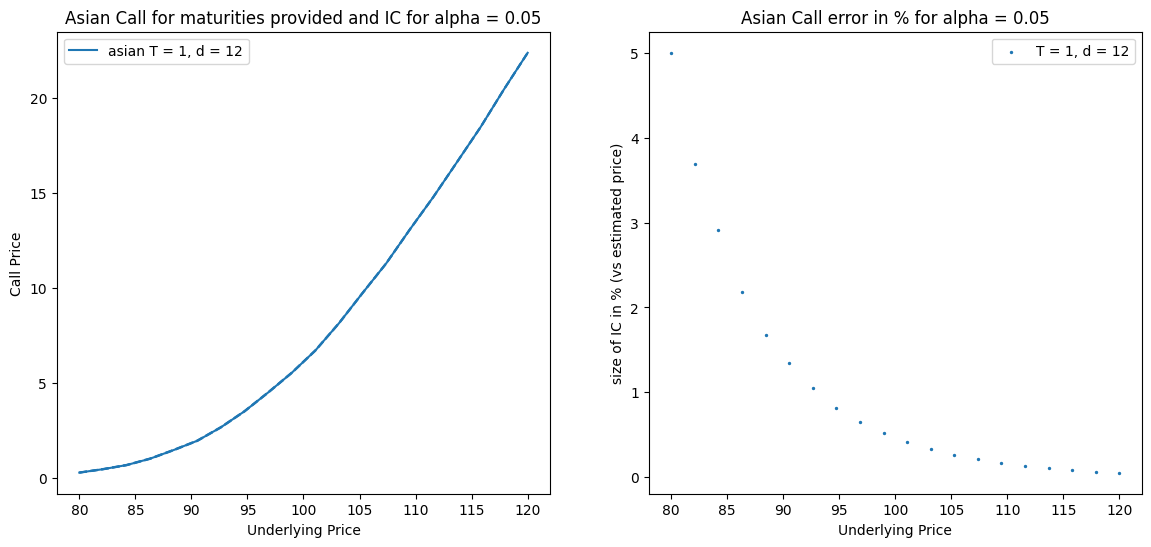

Variance reduction factor is, after emprirical estimation, 0.07


In [9]:
def monte_carlo_asian_call_ST_Z1_Z2(S=100, K=100, T=1, r=0.05, sigma=0.2, d=12, N=int(1e5)):
    step = T / d
    simulations = np.zeros((N, d+1))
    simulations[:,0] = S
    for iter in range(N):
        for t in range(1,d+1):
            dx = np.random.normal()
            simulations[iter, t] = simulations[iter, t-1]*np.exp((r - 0.5 * sigma ** 2) * step + sigma * np.sqrt(step) * dx)
    realized_payoff = np.maximum(np.mean(simulations[:, 1:], axis=1) - K, 0)
    
    ## control variables
    ST = simulations[:, -1]       
    Z1 = np.mean(simulations[:, 1:], axis=1)  
    Z2 = np.maximum(simulations[:, -1] - K, 0)
    #expected values
    E_ST = S * np.exp(r*T)
    E_Z1 = np.mean(Z1)
    E_Z2 = np.mean(Z2)
    
    # this code is not optimal from a memory standing point
    Z = np.array([ST, Z1, Z2]) # shape 3,N
    E_Z = np.array([E_ST, E_Z1, E_Z2]).reshape(3,1) # shape 3
    
    #matrices
    var_Z_inv = np.linalg.inv(np.cov(Z)) # shape (3,3)
    cov_HZ = np.cov(Z,realized_payoff)[:-1,-1] #we keep the last col, H vs each Zi
    
    # here we can approach the optimal c_star by computing rho(payoff,S_T) :
    c_star = - var_Z_inv @ cov_HZ # shape (3,)

    adj_realized = np.exp(-r * T) * (realized_payoff + c_star.T @ (Z - E_Z))
    reduction = cov_HZ.T @ var_Z_inv @ cov_HZ / np.var(realized_payoff)
    
    
    return {'Price': np.mean(adj_realized), 'Variance': np.var(adj_realized), 'Corr' : reduction}

plotting(Unders, Maturities,times, alpha,monte_carlo_asian_call_ST_Z1_Z2)

coeff = 1-monte_carlo_asian_call_ST_Z1_Z2()['Corr']
print(f'Variance reduction factor is, after emprirical estimation, {np.round(coeff,2)}')

Commentaire : réduction d'un diviseur théorique supérieur à 10 (proche de 14). Si le prix de départ à la monnaie T =1 était estimé à +- 100bp, désormais plutôt +- 10bp. En fonction des besoins de l'émetteur, il faudrait peut-être gagner davantage en précision.